In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import spacy
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re,string,unicodedata
import pickle

from tqdm import tqdm
import seaborn as sns

import gensim

In [2]:
print(tf.__version__)

2.15.0


In [3]:
df=pd.read_csv("/kaggle/input/news-of-the-site-folhauol/articles.csv",encoding="utf8")

In [4]:
df.columns

Index(['title', 'text', 'date', 'category', 'subcategory', 'link'], dtype='object')

In [5]:
df.head(3)

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...


In [6]:
df.shape

(167053, 6)

In [7]:
print(df["title"][0],"\n",df["text"][0])

Lula diz que está 'lascado', mas que ainda tem força como cabo eleitoral 
 Com a possibilidade de uma condenação impedir sua candidatura em 2018, o ex-presidente Luiz Inácio Lula da Silva fez, nesta segunda (9), um discurso inflamado contra a Lava Jato, no qual disse saber que está "lascado", exigiu um pedido de desculpas do juiz Sergio Moro e afirmou que, mesmo fora da disputa pelo Planalto, será um cabo eleitoral expressivo para a sucessão de Michel Temer.  Segundo o petista, réu em sete ações penais, o objetivo de Moro é impedir sua candidatura no ano que vem, desidratando-o, inclusive, no apoio a um nome alternativo, como o do ex-prefeito de São Paulo Fernando Haddad (PT), caso ele não possa concorrer à Presidência.  "Eu sei que tô lascado, todo dia tem um processo. Eu não quero nem que Moro me absolva, eu só quero que ele peça desculpas", disse Lula durante um seminário sobre educação em Brasília. "Eles [investigadores] chegam a dizer: 'Ah, se o Lula não for candidato, ele não vai

In [8]:
print('Linhas:',len(df))
df.drop_duplicates(subset=["text"],inplace=True)
print('Removendo duplicadas em "text":',len(df))
df.drop(['subcategory','link','date'],axis=1,inplace=True)
print('Removendo subcategory')
df.dropna(inplace=True)
print('Removendo nulos:',len(df))
df.reset_index(drop=True,inplace=True)
print('Resetando index')
df.head()

Linhas: 167053
Removendo duplicadas em "text": 165902
Removendo subcategory
Removendo nulos: 165901
Resetando index


,title,text,category
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,poder
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,poder
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [9]:
stop = set(stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [10]:
# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate/34294022
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

#Removing the noisy text
def denoise_text(text):
    text = remove_urls(text)
    text = remove_stopwords(text)
    text = remove_punct(text)
    return text

#Apply function on review column
df['text']=df['text'].apply(denoise_text)

In [11]:
print(df["title"][0],"\n",df["text"][0])

Lula diz que está 'lascado', mas que ainda tem força como cabo eleitoral 
 possibilidade condenação impedir candidatura 2018 expresidente Luiz Inácio Lula Silva fez nesta segunda 9 discurso inflamado contra Lava Jato disse saber lascado exigiu pedido desculpas juiz Sergio Moro afirmou que disputa Planalto cabo eleitoral expressivo sucessão Michel Temer Segundo petista réu sete ações penais objetivo Moro impedir candidatura ano vem desidratandoo inclusive apoio nome alternativo exprefeito Paulo Fernando Haddad PT caso possa concorrer Presidência Eu sei tô lascado todo dia processo quero Moro absolva quero peça desculpas disse Lula durante seminário sobre educação Brasília Eles investigadores chegam dizer Ah Lula candidato vai ter força cabo eleitoral Testem completou petista expresidente Moro usou mentiras contadas Polícia Federal Ministério Público julgálo condenálo nove anos seis meses prisão caso tríplex Guarujá SP expresidente disse ainda ter medo investigadores que acordo ele acost

In [12]:
df.head(3)

,title,text,category
0,"Lula diz que está 'lascado', mas que ainda tem...",possibilidade condenação impedir candidatura 2...,poder
1,"'Decidi ser escrava das mulheres que sofrem', ...",Oumou Sangaré cantora ativista malinesa sofrim...,ilustrada
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens Folha vencedoras Prêmio Petro...,poder


<Axes: xlabel='count', ylabel='category'>

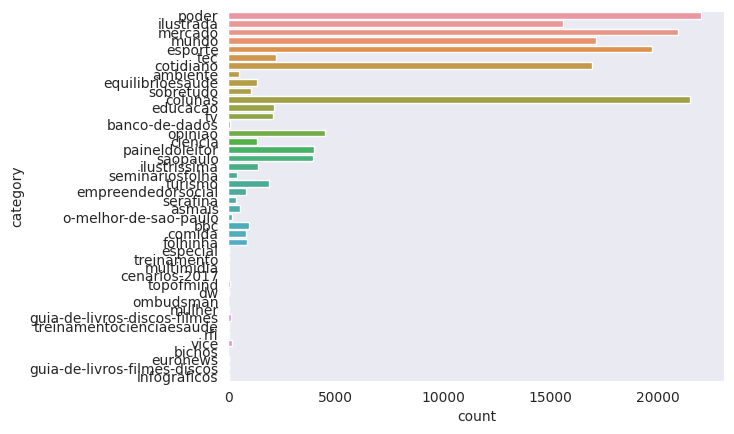

In [13]:
sns.set_style("dark")
sns.countplot(y='category', data=df)

In [14]:
# Contar a frequência de cada categoria
categoria_counts = df['category'].value_counts()

# Pegar as 7 categorias mais frequentes
top_7_categorias = categoria_counts.index[:7]

# Defina todas as categorias que não estão entre as 7 mais frequentes como 'outros'
df.loc[~df['category'].isin(top_7_categorias), 'category'] = 'outros'

<Axes: xlabel='count', ylabel='category'>

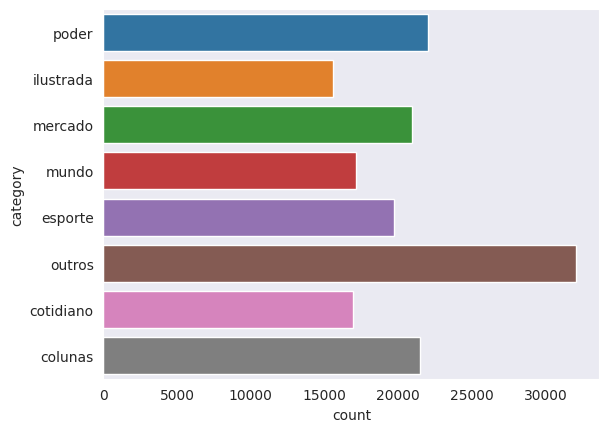

In [15]:
sns.set_style("dark")
sns.countplot(y='category', data=df)

In [16]:
df.columns

Index(['title', 'text', 'category'], dtype='object')

In [17]:
df.shape

(165901, 3)

In [18]:
# Calcular o número de palavras em cada texto
word_counts = [len(str(text).split()) for text in df['text']]

# Encontrar o número máximo de palavras
max_words = max(word_counts)

# Encontrar o número mínimo de palavras
min_words = min(word_counts)

print('Número máximo de palavras:', max_words)
print('Número mínimo de palavras:', min_words)

Número máximo de palavras: 7643
Número mínimo de palavras: 0


## WORD2VEC MODEL USING GENSIM

In [19]:
df.reset_index(drop=True, inplace=True)

articles_tokens=[]
for i in range(len(df["text"])):
    articles_tokens.append([word for word in word_tokenize(str(df["text"][i].lower())) if len(word)>2])

In [20]:
articles_tokens[0][0:10]

['possibilidade',
 'condenação',
 'impedir',
 'candidatura',
 '2018',
 'expresidente',
 'luiz',
 'inácio',
 'lula',
 'silva']

In [72]:
save, load =  False, True
if save: 
    # Salvar articles_tokens como um arquivo pickle
    with open('articles_tokens.pkl', 'wb') as f:
        pickle.dump(articles_tokens, f)
if load:
    # Carregar articles_tokens de um arquivo pickle
    with open('articles_tokens.pkl', 'rb') as f:
        articles_tokens = pickle.load(f)

In [23]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

In [24]:
wv_model = gensim.models.Word2Vec(sentences=articles_tokens, 
                                  min_count=5, 
                                  vector_size=EMBEDDING_DIM, 
                                  workers=4)

In [27]:
wv_model.save('word2vec_v2.model')

In [73]:
wv_model = gensim.models.Word2Vec.load('word2vec_v2.model')

In [29]:
wv_model.wv.most_similar("lula")

[('petista', 0.8261432647705078),
 ('fhc', 0.7629282474517822),
 ('petistas', 0.7359021306037903),
 ('dilma', 0.6709792017936707),
 ('tucano', 0.6589360237121582),
 ('temer', 0.6419598460197449),
 ('expresidente', 0.6163798570632935),
 ('peemedebista', 0.611551821231842),
 ('palocci', 0.5918166637420654),
 ('sucessora', 0.5781452059745789)]

In [30]:
wv_model.wv.most_similar("esporte")

[('esportes', 0.7209888696670532),
 ('futebol', 0.7047557830810547),
 ('mma', 0.6428175568580627),
 ('judô', 0.6048557162284851),
 ('vôlei', 0.5852615237236023),
 ('cbru', 0.5818747282028198),
 ('esportiva', 0.5746078491210938),
 ('basquete', 0.5607158541679382),
 ('handebol', 0.557834267616272),
 ('boxe', 0.5564391016960144)]

In [31]:
print(len(wv_model.wv.key_to_index))

145496


## Model

In [35]:
# Create vocabulary and embedding matrix
max_len = max([len(seq) for seq in articles_tokens])  # Find maximum sequence length
vocab_size = len(wv_model.wv.key_to_index) + 1  # Include padding token (+1)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in wv_model.wv.key_to_index.items():
    embedding_vector = wv_model.wv[word]
    if embedding_vector is not None:  # Handle out-of-vocabulary (OOV) words
        embedding_matrix[i + 1] = embedding_vector  # +1 for padding token

In [36]:
embedding_matrix.shape

(145497, 100)

In [105]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Conv1D, Dropout, MaxPooling1D, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras import regularizers

In [74]:
# O próximo passo é tokenizar o texto
tokenizer = Tokenizer(num_words=3000, split=" ")
tokenizer.fit_on_texts(df['text'].values)

In [40]:
# Transformando o texto em sequência de números e preenchendo sequência para ter o mesmo tamanho
X_seq = tokenizer.texts_to_sequences(df['text'].values)

In [53]:
# padding our text vector so they all have the same length
X_pad = pad_sequences(X_seq, padding="post", truncating="post")

In [54]:
# Categorizando as labels
Y = pd.get_dummies(df['category']).values

In [55]:
print(X_pad.shape)
print(Y.shape)

(165901, 3542)
(165901, 8)


In [64]:
word_to_check = 'condenação'  # substitua por qualquer palavra que você queira verificar

# Obtenha o índice da palavra
index = tokenizer.word_index.get(word_to_check)

if index is not None:
    print(f"A palavra '{word_to_check}' está mapeada para o índice {index} no tokenizer.")
else:
    print(f"A palavra '{word_to_check}' não está no vocabulário do tokenizer.")

A palavra 'condenação' está mapeada para o índice 2850 no tokenizer.


In [61]:
# Crie um mapeamento de índices para palavras
index_to_word = {v: k for k, v in tokenizer.word_index.items()}

In [66]:
# Escolhendo um exemplo para mostrar
example_index = 0

sequence_to_translate = X_seq[example_index]
translated_text = ' '.join(index_to_word[i] for i in sequence_to_translate if i in index_to_word)

print("Texto original: ", df['text'].values[example_index])

# Mostrando a sequência correspondente
print("Sequência correspondente: ", X_seq[example_index])

# Mostrando a sequência após o padding
print("Sequência após o padding: ", X_pad[example_index])

print("Texto traduzido: ", translated_text)

Texto original:  possibilidade condenação impedir candidatura 2018 expresidente Luiz Inácio Lula Silva fez nesta segunda 9 discurso inflamado contra Lava Jato disse saber lascado exigiu pedido desculpas juiz Sergio Moro afirmou que disputa Planalto cabo eleitoral expressivo sucessão Michel Temer Segundo petista réu sete ações penais objetivo Moro impedir candidatura ano vem desidratandoo inclusive apoio nome alternativo exprefeito Paulo Fernando Haddad PT caso possa concorrer Presidência Eu sei tô lascado todo dia processo quero Moro absolva quero peça desculpas disse Lula durante seminário sobre educação Brasília Eles investigadores chegam dizer Ah Lula candidato vai ter força cabo eleitoral Testem completou petista expresidente Moro usou mentiras contadas Polícia Federal Ministério Público julgálo condenálo nove anos seis meses prisão caso tríplex Guarujá SP expresidente disse ainda ter medo investigadores que acordo ele acostumados mexer deputados senadores temem apurações Eu quero 

In [68]:
# Dividindo os dados em conjunto de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X_pad, Y, test_size = 0.3, random_state = 42)

In [69]:
Y_train.shape

(116130, 8)

In [75]:
del articles_tokens, wv_model, tokenizer, Y, X_seq

In [218]:
model = Sequential()

# Load pre-trained embeddings
embedding_layer = Embedding(
    vocab_size, 
    EMBEDDING_DIM, 
    embeddings_initializer=Constant(embedding_matrix), 
    trainable=True
)

model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(Y_train.shape[1], activation='softmax'))

In [219]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = [tf.keras.metrics.F1Score(average="macro")])

In [220]:
earlystop = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

In [221]:
# Treinando o modelo
batch_size = 512
history = model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, callbacks=[earlystop], validation_split=0.2)

Epoch 1/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 126s 592ms/step - f1_score: 0.2261 - loss: 3.8168 - val_f1_score: 0.5338 - val_loss: 1.5576
Epoch 2/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - f1_score: 0.6074 - loss: 1.4032 - val_f1_score: 0.6942 - val_loss: 1.0859
Epoch 3/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - f1_score: 0.7067 - loss: 1.0810 - val_f1_score: 0.7355 - val_loss: 0.9393
Epoch 4/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - f1_score: 0.7491 - loss: 0.9406 - val_f1_score: 0.7610 - val_loss: 0.8328
Epoch 5/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - f1_score: 0.7762 - loss: 0.8469 - val_f1_score: 0.7682 - val_loss: 0.8088
Epoch 6/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - f1_score: 0.7989 - loss: 0.7692 - val_f1_score: 0.7868 - val_loss: 0.7692
Epoch 7/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - f1_score: 0.8130 - loss: 0.7161 - val_f1_score: 0.7881 - val_loss: 0.7436
Epoch 8/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - f1_score: 0.8304 -

In [222]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

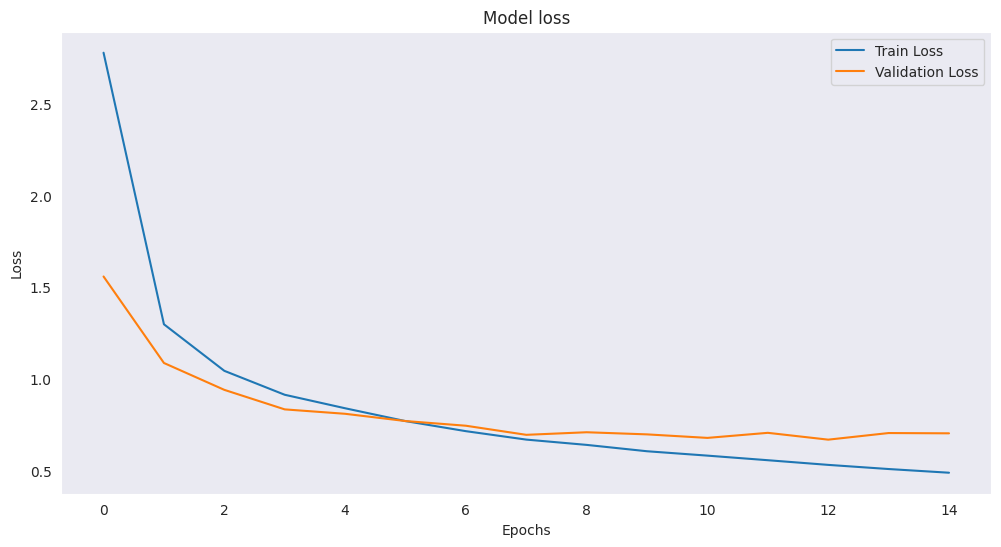

In [223]:
# Plotando a história de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

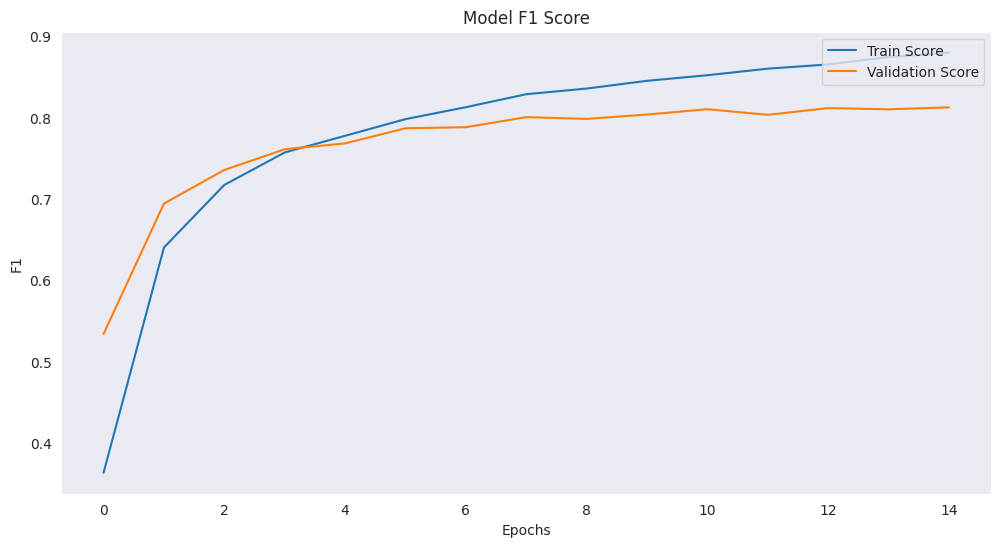

In [224]:
# Plotando a história de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['f1_score'], label='Train Score')
plt.plot(history.history['val_f1_score'], label='Validation Score')
plt.title('Model F1 Score')
plt.ylabel('F1')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

In [225]:
# Gerando o relatório de classificação
Y_test_pred = model.predict(X_test)
Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

1556/1556 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step


In [226]:
print(classification_report(Y_test_classes, Y_test_pred_classes, target_names=df['category'].unique()))

              precision    recall  f1-score   support

       poder       0.76      0.75      0.75      6443
   ilustrada       0.80      0.80      0.80      5093
     mercado       0.94      0.93      0.94      5870
       mundo       0.75      0.86      0.80      4724
     esporte       0.82      0.77      0.80      6286
      outros       0.87      0.83      0.85      5140
   cotidiano       0.78      0.69      0.73      9676
     colunas       0.77      0.91      0.83      6539

    accuracy                           0.81     49771
   macro avg       0.81      0.82      0.81     49771
weighted avg       0.81      0.81      0.81     49771



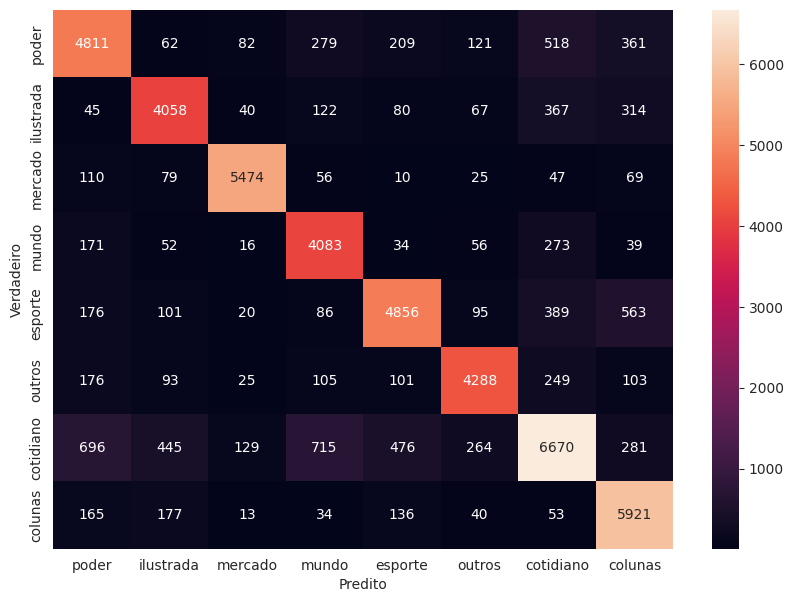

In [230]:
# Gerar a matriz de confusão
cm = confusion_matrix(Y_test_classes, Y_test_pred_classes)

# Criar uma matriz de zeros com a mesma forma da matriz de confusão
mask = np.zeros_like(cm)

# Marcar a metade superior da matriz com True para ocultá-la
mask[np.triu_indices_from(mask, k=1)] = True

# Obter os nomes das classes
class_names = df['category'].unique()

# Visualizar a matriz de confusão
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

In [228]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 3542, 100)      │    14,549,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 3538, 64)       │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 1179, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_41                │ (None, 1179, 64)       │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 1179, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_42                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,895,846 (167.45 MB)

 Trainable params: 14,631,948 (55.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,263,898 (111.63 MB)